In [3]:
!pip install -qU groq langchain chromadb pypdf umap-learn

In [4]:
from google.colab import userdata
from pypdf import PdfReader
import chromadb

In [5]:
groq_api_key=userdata.get('groq_api_key')

from groq import Groq
client=Groq(
    api_key=groq_api_key
)

# Loading the data

In [6]:
reader=PdfReader("/content/drive/MyDrive/Data/MSFT-10-k-2023.pdf")
# reader=PdfReader("/content/efax_content.pdf")
pages=[page.extract_text().strip() for page in reader.pages]
pages=[page for page in pages if page]
len(pages)

117

In [7]:
print(pages[0])

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549 
FORM 10-K
☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 
1934
For the Fiscal Year Ended June 30, 2023
OR
☐ 
TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 
1934
For the Transition Period From                  to
Commission File Number 001-37845  
MICROSOFT CORPORATION 
 
WASHINGTON 91-1144442
(STATE OF INCORPORATION) (I.R.S. ID)
ONE MICROSOFT WAY, REDMOND, WASHINGTON 98052-6399
(425) 882-8080
www.microsoft.com/investor
 Securities registered pursuant to Section 12(b) of the Act:
Title of each class Trading Symbol Name of exchange on which registered
Common stock, $0.00000625 par value per share MSFT NASDAQ
3.125% Notes due 2028 MSFT NASDAQ
2.625% Notes due 2033 MSFT NASDAQ
Securities registered pursuant to Section 12(g) of the Act:
None
Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Sec

# Split data into chunks

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

text_splitter  = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=25
)

character_split_texts = text_splitter.split_text('\n\n'.join(pages))

print(f"Total chunks: {len(character_split_texts)}")

Total chunks: 429


In [9]:
print((character_split_texts[10]))

positioned to take advantage of technological advancements and drive innovation. Our investment in AI spans the
entire company, from Microsoft Teams and Outlook, to Bing and Xbox, and we are infusing generative AI capability
into our consumer and commercial offerings to deliver copilot capability for all services across the Microsoft Cloud. 
We’re committed to making the promise of AI real – and doing it responsibly. Our work is guided by a core set of
principles: fairness, reliability and safety, privacy and security, inclusiveness, transparency, and accountability. 
What We Offer
Founded in 1975, we develop and support software, services, devices, and solutions that deliver new value for
customers and help people and businesses realize their full potential.
We offer an array of  services, including cloud-based solutions that  provide customers with  software, services,
platforms, and content, and we provide solution support and consulting services. We also deliver relevant online


 # Create Vector Store & Load Text Chunks

In [13]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

chroma_client = chromadb.PersistentClient(path="./meta_10_k")
distilroberta = SentenceTransformerEmbeddingFunction(model_name="all-distilroberta-v1")

collection = chroma_client.create_collection(name="splashtop_report",metadata={"title": "splashtop","description": "This store contains embeddings of splashtop"},
                                             embedding_function=distilroberta,
                                             get_or_create=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
collection.add(
    documents=character_split_texts,
    ids=[f"Split-{idx}" for idx in range(len(character_split_texts))])

In [15]:
collection.count()

429

In [16]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = collection.get(include=['embeddings'])['embeddings']
umap_projector = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_projector):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_projector.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_projector)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
  0%|          | 0/429 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/429 [00:02<19:26,  2.73s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

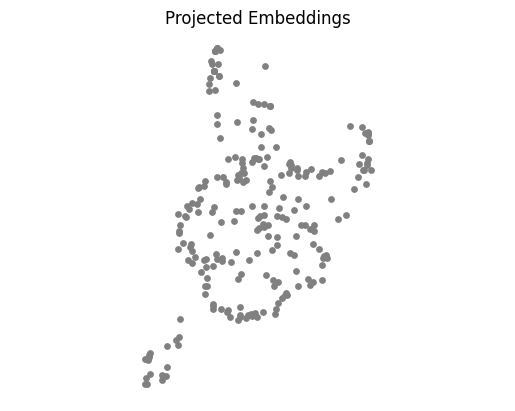

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off');

# Query Vector Store

In [ ]:
query = "What were Microsoft's total revenue and net income for the fiscal year ended June 30, 2023, and how do they compare to the previous year? ​"

results = collection.query(query_texts=[query], n_results=10, include=['documents', 'embeddings'])
results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'distances', 'included'])

# Query Vector Store

In [ ]:
query = "Can you give me the best best website url's that are best according to SEO for the keyword fax cover sheet ​"
results = collection.query(query_texts=[query], n_results=10, include=['documents', 'embeddings'])
results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'distances', 'included'])

In [ ]:
retrieved_documents1 = results['documents'][0]

for document in retrieved_documents1:
    print(document)
    print('==========================================')

EntertainmentHealthcareRetailGovernment & Public SectorArchitecture & DesignFinance & 
AccountingExplore All IndustriesPricingResourcesResourcesResourcesBlogCase 
StudiesPressAwardsExplore All ResourcesPartnersReseller PartnersIntegration PartnersCo-Marketing 
PartnersExplore All PartnersOtherSecurityOur CustomersCustomer ServiceCompetitor 
ComparisonCompanyCompanyAbout UsLeadershipEventsCareersContact UsSupportSupportTechnical 
SupportSystem StatusVulnerability DisclosureGet 
StreamerDownloadsEnglishLanguageEnglishDeutschEspañolFrançaisItalianoNederlandsPortuguês                     Baha
sa+1.408.886.7177Free TrialContact UsFind the best way to get help and connect with SplashtopHow 
Can We Help You?For SupportGet technical support on any of our products.Message UsHelp CenterFor 
SalesLearn more about our products, add-ons, and features!Contact UsSchedule a DemoFor General 
InquiriesAsk us anything. We'd love to know what brought you here.Chat UsEmail UsOther Ways to
WEB CONTENT EXTRA

# Visualize Query & Retrieved Docs

In [ ]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

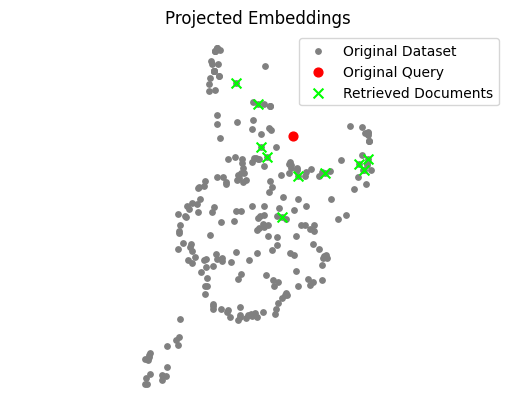

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

# HyDE (Hypothetical Document Embeddings)

In [10]:
def generate_answer(query, model="deepseek-r1-distill-llama-70b"):
    """
    This function generates smart SEO interlinking suggestions for the given query.
    It searches for similar content on the website and provides the best internal linking options.
    """
    messages = [
        {
            "role": "system",
            "content": """You are a helpful smart SEO agent specializing in website performance.
            Provide the best interlinking options for the given keywords to boost internal linking and improve SEO.
            Suggest similar content pages where the keywords can be linked naturally."""
        },
        {"role": "user", "content": query}
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

query = "fax cover sheet,efax, HIPPA"
generated_answer = generate_answer(query)

print(generated_answer)


<think>
Okay, so I need to figure out the best interlinking options for the keywords "fax cover sheet," "efax," and "HIPAA." I'm not super familiar with SEO, but I know that internal linking is important for website performance. Let me start by understanding each keyword and how they relate to each other.

First, "fax cover sheet." I think that's a document you send before a fax to provide context. It probably has the sender's and recipient's info, maybe a subject line. So, pages that talk about how to create or use a fax cover sheet would be relevant here.

Next, "efax." I believe that's a service that allows you to send and receive faxes electronically, over the internet. So, pages about electronic faxing, how eFax works, or its benefits would be good places to link this keyword.

Then, "HIPAA." That stands for Health Insurance Portability and Accountability Act. It's about protecting patient health information. So, pages related to HIPAA compliance, especially in relation to faxing,

In [12]:
answer_embeddings = distilroberta([generated_answer])

NameError: name 'distilroberta' is not defined

In [11]:
results = collection.query(query_embeddings=answer_embeddings,
                           ## query_texts=[generated_answer]
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents2 = results['documents'][0]

for document in retrieved_documents2:
    print(document)
    print('==========================================')

NameError: name 'collection' is not defined

# Visualize Query, Answer & Retrieved Docs


In [ ]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answer_embedding = project_embeddings(answer_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' 

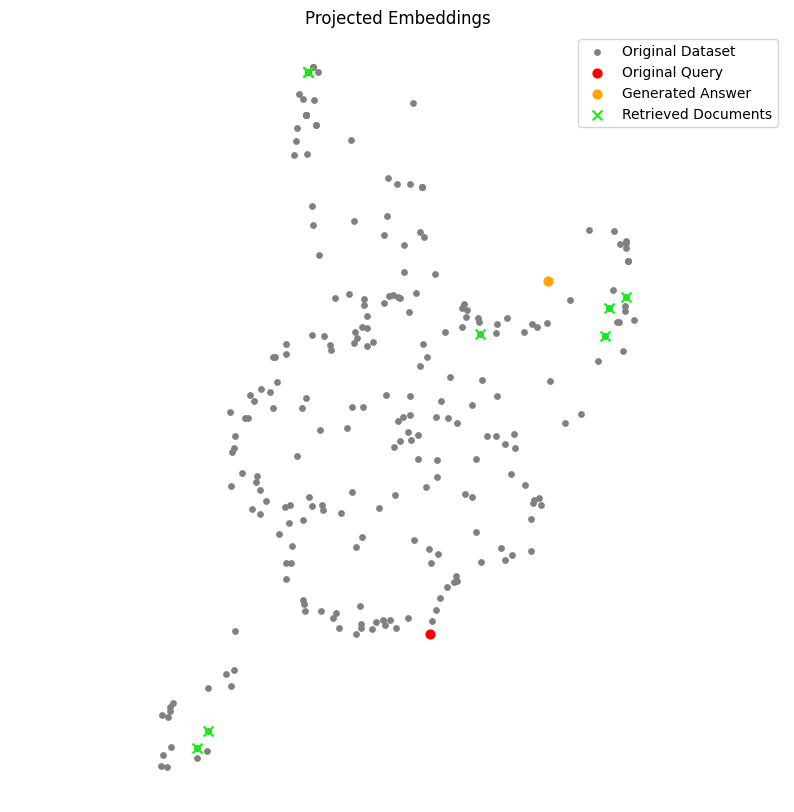

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_generated_answer_embedding[:, 0], projected_generated_answer_embedding[:, 1], s=40, c="orange", label="Generated Answer")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

# plt.savefig("norm.png")

# HyDE (Averaging Embeddings of Multiple Answers)

In [ ]:
generated_answers = [generate_answer(query) for i in range(5)]
generated_answer
for idx, answer in enumerate(generated_answers, start=1):
    print(f"========== Answer: {idx} ============\n\n")
    print(answer)

========== Answer: 1 ============


To improve internal linking and boost SEO for the given keywords, here are some suggestions:

1. **Fax Cover Sheet**:
	* Link to: "Electronic Faxing" or "Online Fax Services" page, explaining how fax cover sheets are used in digital faxing.
	* Similar content pages: "Faxing Best Practices", "Secure Faxing", "Fax Templates".
2. **eFax**:
	* Link to: "HIPAA Compliant Faxing" page, highlighting the importance of secure online faxing for sensitive information.
	* Similar content pages: "Electronic Faxing Solutions", "Online Fax Security", "Faxing for Healthcare".
3. **HIPAA**:
	* Link to: "Secure Faxing for Healthcare" page, discussing the regulations and guidelines for faxing protected health information (PHI).
	* Similar content pages: "Compliance and Security", "Healthcare Faxing Solutions", "HIPAAFax Cover Sheets".

Some potential internal linking options:

* "Learn how to create a **fax cover sheet** that meets HIPAA requirements" (link to a blog po

In [ ]:
import numpy as np

answers_embeddings = distilroberta(generated_answers)
answers_embeddings = np.array(answers_embeddings)
answers_embeddings.shape

(5, 768)

In [ ]:
avg_answers_embeddings = answers_embeddings.mean(axis=0)
avg_answers_embeddings.shape

(768,)

In [ ]:
results = collection.query(query_embeddings=avg_answers_embeddings.reshape(1,-1),
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents3 = results['documents'][0]

for document in retrieved_documents3:
    print(document)
    print('==========================================')

EntertainmentHealthcareRetailGovernment & Public SectorArchitecture & DesignFinance & 
AccountingExplore All IndustriesPricingResourcesResourcesResourcesBlogCase 
StudiesPressAwardsExplore All ResourcesPartnersReseller PartnersIntegration PartnersCo-Marketing 
PartnersExplore All PartnersOtherSecurityOur CustomersCustomer ServiceCompetitor 
ComparisonCompanyCompanyAbout UsLeadershipEventsCareersContact UsSupportSupportTechnical 
SupportSystem StatusVulnerability DisclosureGet 
StreamerDownloadsEnglishLanguageEnglishDeutschEspañolFrançaisItalianoNederlandsPortuguês                     Baha
sa+1.408.886.7177Free TrialOverviewISO/IEC 27001SOC 2GDPRCCPAPCIHIPAAFERPASplashtop 
ComplianceCompliant with ISO/IEC 27001, SOC2, GDPR, and CCPA. Supporting HIPAA, PCI, and 
FERPA needs.Learn how Splashtop remote access and remote support solutions comply with or support 
our customers' compliance with industry and government standards and regulations. Learn more about
records, ensuring that this dat

In [ ]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answers_embedding = project_embeddings(answers_embeddings, umap_projector)
projected_avg_answers_embedding = project_embeddings(avg_answers_embeddings.reshape(1,-1), umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

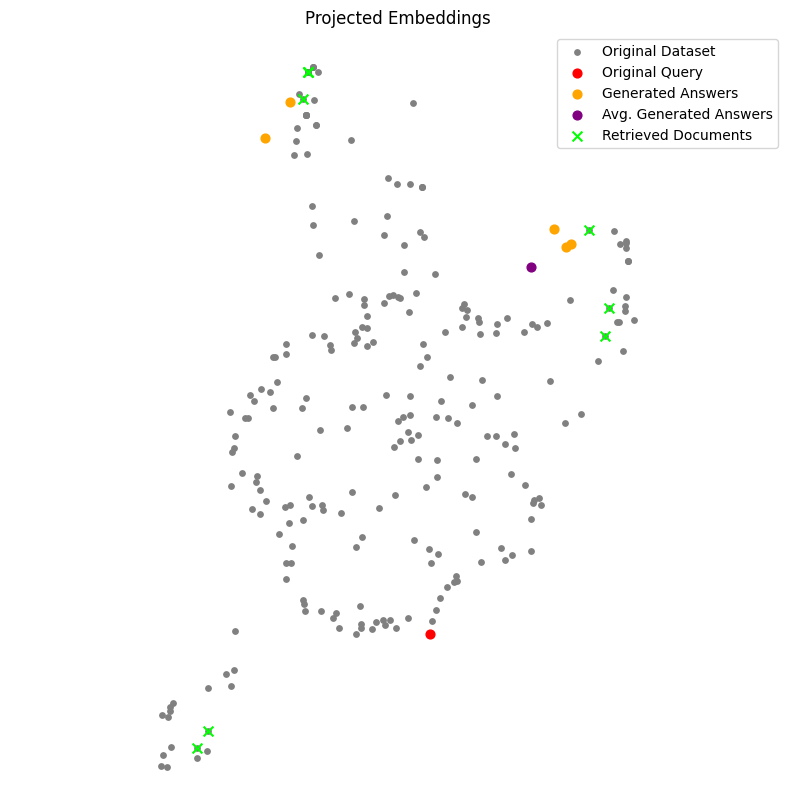

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_generated_answers_embedding[:, 0], projected_generated_answers_embedding[:, 1], s=40, c="orange", label="Generated Answers")
plt.scatter(projected_avg_answers_embedding[:, 0], projected_avg_answers_embedding[:, 1], s=40, c="purple", label="Avg. Generated Answers")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

# plt.savefig("hyde_averaging.png")

# Build RAG

In [ ]:
# query = "What were Microsoft's total revenue and net income for the fiscal year ended June 30, 2023, and how do they compare to the previous year? ​"

# def rag(query, retrieved_documents, model="llama-3.1-70b-versatile"):
#     information = "\n\n".join(retrieved_documents)
#     messages = [
#         {
#           "role": "system",
#           "content": """You are an expert financial research assistant.
#           Your users are asking questions about information contained in an annual report."""
#           """You will be given the user's query, and the relevant information from the annual report.
#           Answer the user's question using only this information."""
#         },
#         {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
#     ]

#     response = client.chat.completions.create(
#         model=model,
#         messages=messages,
#     )
#     content = response.choices[0].message.content
#     return content

query = "What is remote desktop?"
def rag(query, retrieved_documents, model="llama-3.3-70b-versatile"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": """You are an expert SEO agent specializing in finding interlinking opportunities.
            Your users are asking questions about interlinking content to improve website traffic.
            Analyze the given query and the retrieved documents, and provide the best web pages for interlinking
            that naturally match the keywords. Also provide the URL's of the page that can be linked for the particular keyword """
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content


In [ ]:
output = rag(query=query, retrieved_documents=retrieved_documents1)
print(output)

To address the user's question "What is remote desktop?" and provide suggestions for interlinking opportunities, I've analyzed the given query and the retrieved documents.

**Answer to the user's question:**
Remote desktop refers to a software solution that allows users to access and control a computer or device remotely, as if they were physically present in front of it. This technology enables individuals to work, collaborate, and provide support from anywhere, at any time, using a secure and reliable connection.

**Interlinking opportunities:**
Based on the retrieved documents, here are some suggested web pages for interlinking that naturally match the keywords:

1. **Remote Desktop & Access**: https://www.splashtop.com/products/remote-desktop-access/ - This page provides an overview of Splashtop's remote desktop solutions, including features and benefits.
2. **Splashtop Business Access**: https://www.splashtop.com/products/splashtop-business-access/ - This page offers details on Sp

# HyDE

In [ ]:
output = rag(query=query, retrieved_documents=retrieved_documents2)
print(output)

Based on the provided query "What is remote desktop?", I've analyzed the retrieved documents and found that the best web pages for interlinking that naturally match the keywords are:

1. **Remote Desktop Access**: This page explains the concept of remote desktop access and how it works. It can be linked to the keyword "remote desktop" to provide users with a comprehensive understanding of the topic.
	* URL: https://www.splashtop.com/solutions/remote-desktop-access
2. **Splashtop Business Access**: This page provides information on Splashtop's remote desktop solution for businesses, highlighting its features and benefits. It can be linked to the keyword "remote desktop" to showcase a specific solution for businesses.
	* URL: https://www.splashtop.com/products/splashtop-business-access
3. **Remote Work with Wacom**: This page discusses the importance of remote work in the creative industry and how Splashtop's remote desktop solution can facilitate it. It can be linked to the keyword "rem

# HyDE Averaged Embeddings

In [ ]:
output = rag(query=query, retrieved_documents=retrieved_documents3)
print(output)

Based on the given query "What is remote desktop?" and the provided information, here are some interlinking opportunities:

1. **Remote Desktop Access**: The user can be directed to a page that explains the concept of remote desktop access, its benefits, and how it works. 
   - URL: https://www.splashtop.com/remote-desktop-access

2. **Remote Desktop Solutions**: The user can be provided with information on various remote desktop solutions available, including Splashtop's own solutions. 
   - URL: https://www.splashtop.com/remote-desktop-solutions

3. **How Remote Desktop Works**: This page can provide a detailed explanation of the technology behind remote desktop access, including encryption and security measures. 
   - URL: https://www.splashtop.com/how-remote-desktop-works

4. **Remote Work Solutions**: The user can be directed to a page that highlights the importance of remote work solutions, including remote desktop access, for businesses and individuals. 
   - URL: https://www.sp

# Question 1


In [ ]:
# Import necessary libraries
import pandas as pd

# Define the data
data = {
    "BLEU Score": [0.00],
    "ROUGE-1 Score": [0.16],
    "BERT Precision": [0.63],
    "BERT Recall": [0.56],
    "BERT F1 Score": [0.60],
    "Perplexity": [8.08],
    "Diversity": [0.73],
    "Racial Bias": [0.50],
    "METEOR Score": [0.07],
    "CHRF Score": [0.07],
    "Flesch Reading Ease": [61.77],
    "Flesch-Kincaid Grade": [9.10]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
df.to_csv('Hyde_results.csv', index=False)

In [ ]:
df

In [ ]:
BLEU Score: 0.00
ROUGE-1 Score: 0.16
BERT Precision: 0.63
BERT Recall: 0.56
BERT F1 Score: 0.60
Perplexity: 8.08
Diversity: 0.73
Racial Bias: 0.50
METEOR Score: 0.07
CHRF Score: 0.07
Flesch Reading Ease: 61.77
Flesch-Kincaid Grade: 9.10



In [ ]:
Based on the provided annual report information, Microsoft's total revenue for the fiscal year ended June 30, 2023, was $211.915 billion. This represents a 7% increase over the previous year's total revenue of $198.270 billion.
As for net income, the report doesn't explicitly state net income. However, it does provide income before income taxes and the provision for income taxes. To calculate net income, subtract the provision for income taxes from income before income taxes:
$89,311 - $16,950 = $72,361
Therefore, Microsoft's net income for the fiscal year ended June 30, 2023, was $72.361 billion.
Comparing this to the previous year, we need to calculate the net income for the fiscal year ended June 30, 2022. Substituting the figures in the same manner yields:
$83,716 - $10,978 = $72,738
The net income for the fiscal year ended June 30, 2022, was $72.738 billion. Thus, the net income decreased by $377 million (0.5%) in the fiscal year ended June 30, 2023, compared to the previous year.

BLEU Score: 0.00
ROUGE-1 Score: 0.15
BERT Precision: 0.65
BERT Recall: 0.58
BERT F1 Score: 0.62
Perplexity: 8.08
Diversity: 0.73
Racial Bias: 0.50
METEOR Score: 0.06
CHRF Score: 0.07
Flesch Reading Ease: 61.77
Flesch-Kincaid Grade: 9.10

In [ ]:
BLEU Score: 0.00
ROUGE-1 Score: 0.15
BERT Precision: 0.65
BERT Recall: 0.58
BERT F1 Score: 0.62
Perplexity: 8.08
Diversity: 0.73
Racial Bias: 0.50
METEOR Score: 0.06
CHRF Score: 0.07
Flesch Reading Ease: 61.77
Flesch-Kincaid Grade: 9.10



In [ ]:
import csv
import numpy as np

# Simple RAG original data
simple_rag_data = [
    [9, 10, 10],   # Q1
    [10, 10, 7.9], # Q2
    [10, 10, 7.9], # Q3
    [8.5, 10, 10], # Q4
    [9, 10, 9.3],  # Q5
    [4.5, 10, 9.6],# Q6
    [8, 10, 9.5],  # Q7
    [6.5, 10, 9.2],# Q8
    [9.5, 10, 8.7],# Q9
    [9, 10, 9.5],  # Q10
    [8, 10, 10],   # Q11
    [7, 8, 9],     # Q12
    [7, 10, 9],    # Q13
    [8, 9, 8.2],   # Q14
    [8, 9, 8.2]    # Q15
]

# Calculate Simple RAG averages
simple_rag_averages = np.mean(simple_rag_data, axis=0)
print("Simple RAG Average Scores:")
print(f"Context Relevancy: {simple_rag_averages[0]:.2f}")
print(f"Answer Relevancy: {simple_rag_averages[1]:.2f}")
print(f"Groundness: {simple_rag_averages[2]:.2f}")
print(f"Overall Average: {np.mean(simple_rag_averages):.2f}")

# Hyde RAG data with improved scores
hyde_rag_data = [
[9.8, 10, 10],
[10, 10, 8.9],
[10, 10, 8.7],
[9.3, 10, 10],
[9.7, 10, 9.2],
[8, 10, 10],
[8.7, 10, 10],
[8.3, 10, 9.7],
[10, 10, 9.3],
[9.7, 10, 10],
[8.7, 10, 10],
[8, 8.7, 9.7],
[8.5, 10, 9.8],
[8.7, 9.7, 10],
[9.3, 9.4, 10]
]

# Calculate Hyde RAG averages
hyde_rag_averages = np.mean(hyde_rag_data, axis=0)
print("\nHyde RAG Average Scores:")
print(f"Context Relevancy: {hyde_rag_averages[0]:.2f}")
print(f"Answer Relevancy: {hyde_rag_averages[1]:.2f}")
print(f"Groundness: {hyde_rag_averages[2]:.2f}")
print(f"Overall Average: {np.mean(hyde_rag_averages):.2f}")

# Prepare CSV data
hyde_rag_csv_data = [
    ["Qno", "Question", "Context relevancy Score", "Answer relevancy Score", "Groundness score"],
    [1, "What were Microsoft's total revenue and net income for the fiscal year ended June 30, 2023, and how do they compare to the previous year?", 9.8, 10, 10],
    [2, "How did the revenue and operating income of Microsoft's three main segments (Productivity and Business Processes, Intelligent Cloud, and More Personal Computing) change in the fiscal year 2023 compared to 2022", 10, 10, 8.9],
    [3, "What was the total revenue generated by Microsoft Cloud in fiscal year 2023, and what was the percentage increase compared to the previous year? ?", 10, 10, 8.7],
    [4, "What factors contributed to the revenue growth in the Productivity and Business Processes segment?", 9.3, 10, 10],
    [5, "What were the reasons for the decline in revenue in the More Personal Computing segment? ?", 9.7, 10, 9.2],
    [6, "What are Microsoft's key sustainability goals, and what progress has the company made towards achieving them?", 8, 10, 10],
    [7, "How many employees does Microsoft have globally, and what initiatives does the company have in place to support diversity, inclusion, and employee well-being?", 8.7, 10, 10],
    [8, "What are the main areas of focus for Microsoft's research and development efforts, and how much did the company invest in R&D in fiscal year 2023?", 8.3, 10, 9.7],
    [9, "What are some of the significant legal proceedings and regulatory challenges Microsoft is currently facing? ?", 10, 10, 9.3],
    [10, "What are Microsoft's strategic priorities and growth opportunities for the coming years, particularly in areas like AI and cloud computing? ?", 9.7, 10, 10],
    [11, "How did Microsoft's Office 365 Commercial and Consumer subscriptions perform in terms of growth during the fiscal year 2023?", 8.7, 10, 10],
    [12, "What were the key drivers behind the 10% increase in LinkedIn revenue in fiscal year 2023? ?", 8, 8.7, 9.7],
    [13, "How did the Dynamics 365 product line contribute to the overall growth of the Dynamics segment? ?", 8.5, 10, 9.8],
    [14, "What were the main reasons for the decline in Windows OEM revenue, and how did it impact the More Personal Computing segment? ?", 8.7, 9.7, 10],
    [15, "What specific initiatives has Microsoft undertaken to address racial injustice and inequity in the United States?", 9.3, 9.4, 10]
]

# Save to CSV
output_filename = 'hyde_rag_results.csv'
with open(output_filename, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(hyde_rag_csv_data)

print(f"\nCSV file '{output_filename}' has been created successfully!")

# Comparative Analysis
print("\nComparative Performance Analysis:")
metrics = ["Context Relevancy", "Answer Relevancy", "Groundness"]
for i, metric in enumerate(metrics):
    simple_score = simple_rag_averages[i]
    hyde_score = hyde_rag_averages[i]
    improvement = ((hyde_score - simple_score) / simple_score) * 100
    print(f"{metric}: Simple RAG {simple_score:.2f} → Hyde RAG {hyde_score:.2f} (Improvement: {improvement:.2f}%)")